In [160]:
import matplotlib.pyplot as plt
import numpy as np

from common import NGSpiceRaw

%matplotlib widget

In [161]:
data = NGSpiceRaw("simulation/tgate_tb.raw", live=True)
print("Fields:", data.names)

Loaded 1 plots from simulation/tgate_tb.raw
Fields: ('time', 'v(vdd)', 'v(vss)', 'v(x1.ctrl_ni)', 'v(ctrl)', 'v(x1.x2.net1)', 'v(x1.ctrl_i)', 'v(out_p)', 'v(in_p)', 'v(x2.ctrl_ni)', 'v(x2.x2.net1)', 'v(x2.ctrl_i)', 'v(out_n)', 'v(in_n)', 'i(vctrl)', 'i(vinn)', 'i(vinp)', 'i(vss)', 'i(vdd)', 'v(n.x2.xm1.nsg13_lv_pmos#NOI)', 'v(n.x2.xm1.nsg13_lv_pmos#GP)', 'v(n.x2.xm1.nsg13_lv_pmos#SI)', 'v(n.x2.xm1.nsg13_lv_pmos#DI)', 'v(n.x2.xm1.nsg13_lv_pmos#BP)', 'v(n.x2.xm1.nsg13_lv_pmos#BI)', 'v(n.x2.xm1.nsg13_lv_pmos#BS)', 'v(n.x2.xm1.nsg13_lv_pmos#BD)', 'v(n.x2.xm1.nsg13_lv_pmos#INT1)', 'v(n.x2.xm1.nsg13_lv_pmos#INT2)', 'v(n.x2.xm1.nsg13_lv_pmos#INT3)', 'v(n.x2.xm1.nsg13_lv_pmos#INT4)', 'v(n.x2.xm1.nsg13_lv_pmos#INT5)', 'v(n.x2.xm1.nsg13_lv_pmos#INT6)', 'v(n.x2.xm1.nsg13_lv_pmos#INT7)', 'v(n.x2.xm1.nsg13_lv_pmos#INT8)', 'v(n.x2.xm1.nsg13_lv_pmos#INT9)', 'v(n.x2.xm1.nsg13_lv_pmos#flow(RES1))', 'v(n.x2.xm1.nsg13_lv_pmos#flow(SPLINE1))', 'v(n.x2.xm1.nsg13_lv_pmos#flow(RES2))', 'v(n.x2.xm1.nsg13_lv_p

In [162]:
F_SAMPLING = 80e6
N = 128
BASE_HARMONIC = 3
F_SIGNAL = F_SAMPLING / N * BASE_HARMONIC

In [163]:
times = data['time']
vin_n = data['v(in_n)']
vin_p = data['v(in_p)']
vout_n = data['v(out_n)']
vout_p = data['v(out_p)']

Loaded 1 plots from simulation/tgate_tb.raw
Loaded 1 plots from simulation/tgate_tb.raw
Loaded 1 plots from simulation/tgate_tb.raw
Loaded 1 plots from simulation/tgate_tb.raw
Loaded 1 plots from simulation/tgate_tb.raw


In [164]:
vin = vin_p - vin_n
vout = vout_p - vout_n

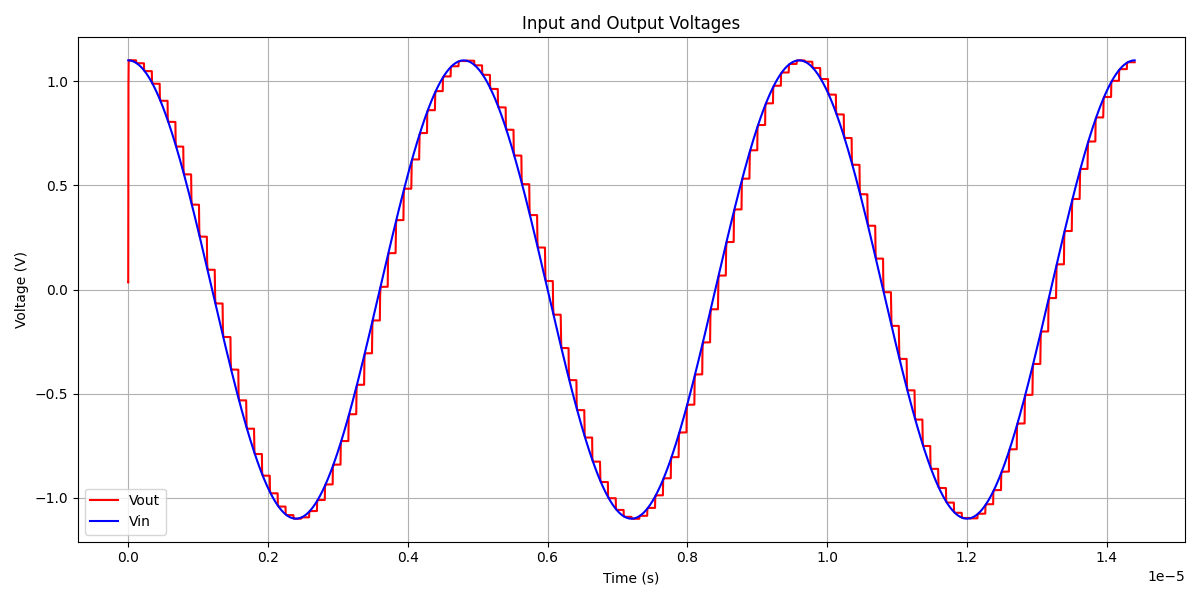

In [165]:
plt.figure(figsize=(12, 6))
plt.plot(times, vout, label='Vout', color='red')
plt.plot(times, vin, label='Vin', color='blue')
plt.title('Input and Output Voltages')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Number of samples: 128
Frequency bin size: 69444.44444444444
Sampling error (p-p): 9.9 mV


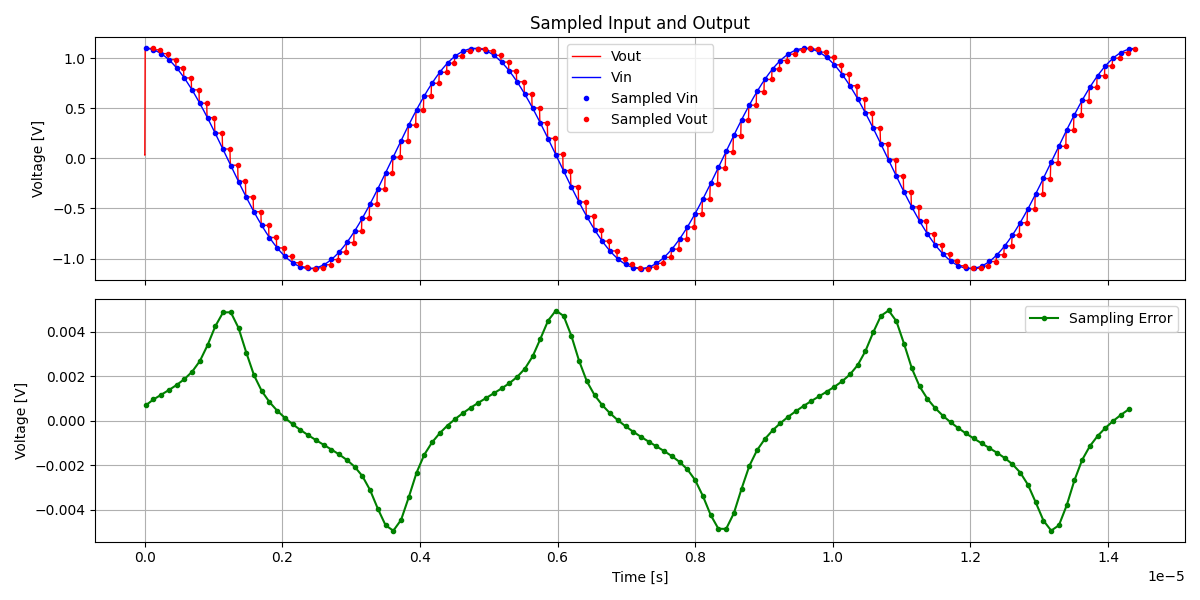

In [166]:
sampling_times_in = [0.99 / F_SAMPLING]
while sampling_times_in[-1] < times[-1]:
    sampling_times_in.append(sampling_times_in[-1] + 9 / F_SAMPLING)

sampling_times_out = [8.99 / F_SAMPLING]
while sampling_times_out[-1] < times[-1]:
    sampling_times_out.append(sampling_times_out[-1] + 9 / F_SAMPLING)

sampling_times_in = np.array(sampling_times_in)[:-1] # Remove the last time to avoid oversampling
sampling_times_out = np.array(sampling_times_out)[:-1] # Remove the last time to avoid oversampling
sampling_vin = np.interp(sampling_times_in, times, vin)
sampling_vout = np.interp(sampling_times_out, times, vout)
sampling_times_in = sampling_times_in
sampling_times_out = sampling_times_out
sampling_error = sampling_vout - sampling_vin

assert N == len(sampling_times_in)
assert N == len(sampling_times_out)
f_bin = F_SAMPLING / N / 9
print("Number of samples:", N)
print("Frequency bin size:", f_bin)
print(f"Sampling error (p-p): {(np.max(sampling_error) - np.min(sampling_error))*1e3:.1f} mV")

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax[0].plot(times, vout, label='Vout', color='red', linewidth=1)
ax[0].plot(times, vin, label='Vin', color='blue', linewidth=1)
ax[0].plot(sampling_times_in, sampling_vin, label='Sampled Vin', color='blue', marker='o', markersize=3, linestyle='None')
ax[0].plot(sampling_times_out, sampling_vout, label='Sampled Vout', color='red', marker='o', markersize=3, linestyle='None')
ax[0].set_title('Sampled Input and Output')
ax[0].set_ylabel('Voltage [V]')
ax[0].grid()
ax[0].legend()
ax[1].plot(sampling_times_in, sampling_error, label='Sampling Error', color='green', marker='o', markersize=3)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Voltage [V]')
ax[1].grid()
ax[1].legend()
plt.tight_layout()
plt.show()

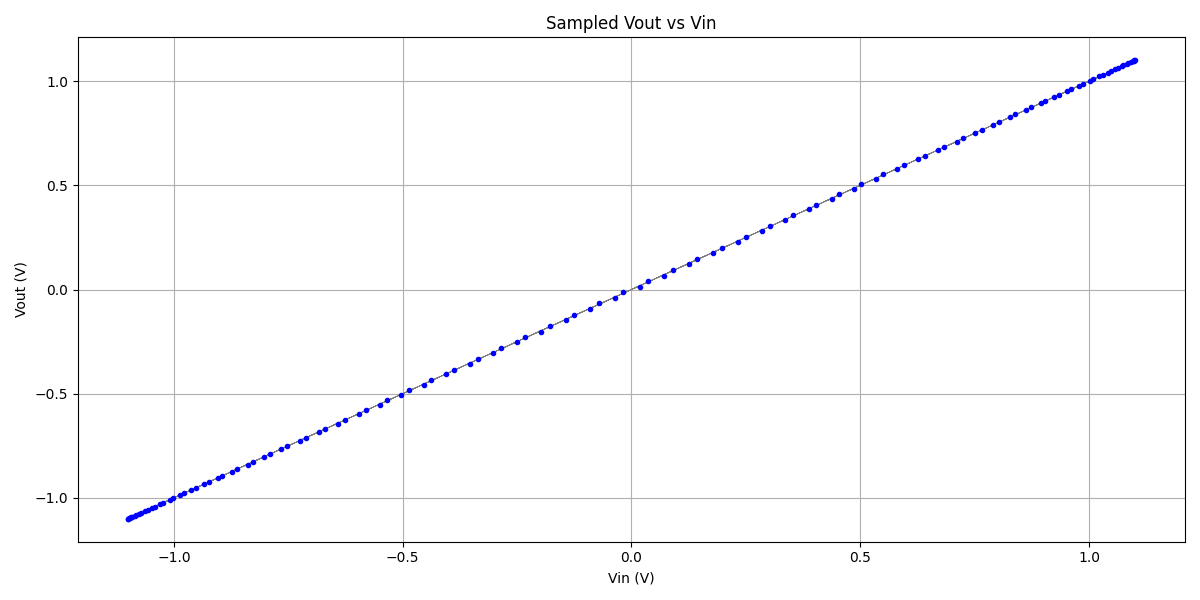

In [167]:
plt.figure(figsize=(12, 6))
plt.plot(sampling_vin[:-1], sampling_vin[:-1], color='gray', linewidth=0.5)
plt.plot(sampling_vin[:-1], sampling_vout[:-1], marker='o', markersize=3, linestyle='None', color='blue')
plt.title('Sampled Vout vs Vin')
plt.xlabel('Vin (V)')
plt.ylabel('Vout (V)')
plt.grid()
plt.tight_layout()
plt.show()

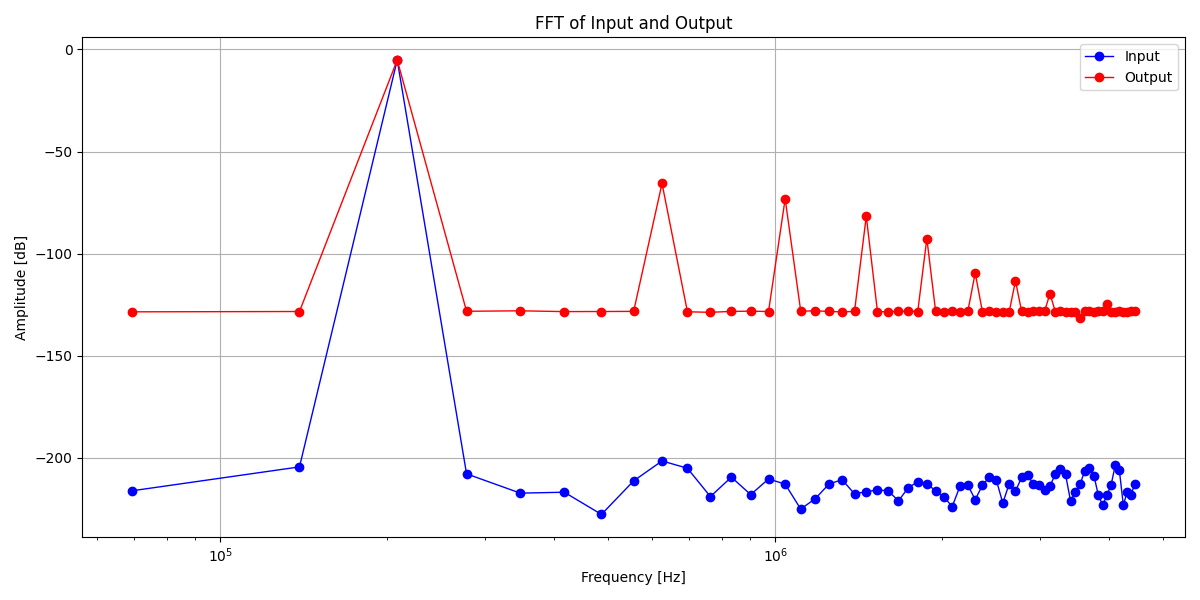

In [168]:
# FFT of input and output signals
yf_vin = np.fft.rfft(sampling_vin) / N
yf_vout = np.fft.rfft(sampling_vout) / N
xf = np.fft.rfftfreq(N, 9 / F_SAMPLING)

yf_vin = np.abs(yf_vin[xf > 0])
yf_vout = np.abs(yf_vout[xf > 0])
xf = xf[xf > 0]

plt.figure(figsize=(12, 6))
plt.plot(xf, 20 * np.log10(yf_vin), 'o-', label='Input', color='blue', linewidth=1)
plt.plot(xf, 20 * np.log10(yf_vout), 'o-', label='Output', color='red', linewidth=1)
# plt.plot(xf, 20 * np.log10(yf_vout) - 20 * np.log10(yf_vin), 'o-', label='Error', color='green', linewidth=1)
plt.title('FFT of Input and Output')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
# plt.xlim(0, 1.5 * F_SIGNAL)
plt.xscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [169]:
def compute_thd(signal, fundamental_index):
    N = len(signal)
    yf = np.fft.rfft(signal) / N
    
    fundamental_amplitude = np.abs(yf[fundamental_index])
    
    max_h = (len(yf) - 1) // fundamental_index
    harmonics_amplitude = np.sqrt(sum(np.abs(yf[h * fundamental_index])**2 for h in range(2, max_h + 1)))
    
    thd = harmonics_amplitude / fundamental_amplitude
    return thd

def compute_sdr(signal, fundamental_index):
    return 20 * np.log10(1 / compute_thd(signal, fundamental_index))

def compute_enob(signal, fundamental_index):
    return compute_sdr(signal, fundamental_index) / 6.02

thd_vin = compute_thd(sampling_vin, BASE_HARMONIC)
thd_vout = compute_thd(sampling_vout, BASE_HARMONIC)
sdr_vin = compute_sdr(sampling_vin, BASE_HARMONIC)
sdr_vout = compute_sdr(sampling_vout, BASE_HARMONIC)
enob_vin = compute_enob(sampling_vin, BASE_HARMONIC)
enob_vout = compute_enob(sampling_vout, BASE_HARMONIC)

print("\tTHD\tSDR\t\tENOB")
print(f"Vin:\t{thd_vin:.2%}\t{sdr_vin:.2f} dB\t{enob_vin:.2f} bits")
print(f"Vout:\t{thd_vout:.2%}\t{sdr_vout:.2f} dB\t{enob_vout:.2f} bits")

	THD	SDR		ENOB
Vin:	0.00%	192.17 dB	31.92 bits
Vout:	0.10%	59.64 dB	9.91 bits
